# SONGS CLASSIFIER 
## Machine learning system that clusterizes songs, based on its analysis provided directly from Spotify's API service.
#### Ivan Yahir Gómez Mancilla - Ivan Ibarra Antonio Alfaro
#### *Proyecto Final | Aprendizaje Inteligente | Ingenieria en Computacion Inteligente | Universidad Autonoma de Aguascalientes*

### Techincal specs
- Category: Unsupervised Clusterization
- Web Scrapping: Spotify API
    - Song's name
    - Artist's name
    - Song's loudness
    - Song's tempo
    - Song's time signature
    - Song's key
    - Song's mode
- Data Preprocessing: Principal Component Analysis
- Machine Learning Model: KMeans
- Evaluation metrics: Silouhette Coefficient, Calinski-Harabasz Index, Davies-Bouldin Index

- IMPORTS

In [37]:
# General
import numpy
import pandas

# API Consuming
import requests
import base64
import json

# Machine learning
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Plotting
import matplotlib.pyplot as plt

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score


- GLOBAL VARIABLES

In [38]:
# API client credentials
client_id = 'ce7fc85dbeaa40588c0a73a324a7654b'
client_secret = '8388086841354dd4bada7a48dfe91b72'


- FUNCTIONS

In [39]:
# Retrieves and convert token for using at Spotify's API
def get_token() :
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")

    url = 'https://accounts.spotify.com/api/token'
    headers = {
        "Authorization" : "Basic " + auth_base64,
        "content-Type" : "application/x-www-form-urlencoded"
    }
    data = {"grant_type" : "client_credentials"}

    result = requests.post(url, headers = headers, data = data)

    json_result = json.loads(result.content)
    token = json_result["access_token"]

    return token


In [40]:
# Gives token a usable format to use in headers when requesting from API
def get_auth_header(token):
    return {"Authorization" : "Bearer " + token}


In [41]:
# Retrieves infomation from API from several tracks with their spotify ID's separeted by a coma (max 50 spotify ID's)
def search_several_tracks(token, tracks):
    url = 'https://api.spotify.com/v1/tracks'
    headers = get_auth_header(token)
    query = f"?ids={tracks}"

    query_url = url + query

    result = requests.get(query_url, headers=headers)

    json_result = json.loads(result.content)

    print(json_result)


In [42]:
# Retrieves audio analysis from API from a single track
def audio_analysis(token, track_id):
    url = 'https://api.spotify.com/v1/audio-analysis/'
    headers = get_auth_header(token)
    query_url = url + track_id

    result = requests.get(query_url, headers = headers)

    json_result = json.loads(result.content)

    return json_result


In [43]:
# Retrieves information from API from a single track
def audio_information(token, track_id):
    url = 'https://api.spotify.com/v1/tracks/'
    headers = get_auth_header(token)
    query_url = url + track_id

    result = requests.get(query_url, headers = headers)

    json_result = json.loads(result.content)

    return json_result


In [44]:
# Returns a list whit general info from a track analysis (duration, loudness, tempo, time_signature, key, mode)
def creates_general_info(track_analysis):
    track = track_analysis["track"]
    general = [track["loudness"], track["tempo"], track["time_signature"], track["key"], track["mode"]]
    
    return general


In [45]:
# Applies PCA to a list of values returnins only 'components parameter' number of principal componentes
def pca(info, components) :
    pca = PCA(n_components=components)
    x = pca.fit_transform(info)

    return x


In [46]:
# Processes a single track by their Spotify ID creating our usable analysis
def track_analysis(token, trackID):
    track_analysis = audio_analysis(token, trackID)

    track_data = creates_general_info(track_analysis)

    return track_data

- MAIN

        -  Data set construction

In [47]:
# Retrieves a token
token = get_token()

In [48]:
# Opens a .txt file containing track's spotify ID's *each track must end with a newline and the EOF is represented by a blank line* 
tracks = open('prueba.txt', 'r')

In [49]:
# Creates a dataframe to store tracks analysis
data_set = pandas.DataFrame()

In [50]:
# Creates a list to store song_name - artist_name
row_names = []

In [51]:
# Iterate over .txt file concatenating each track analysis and name - artist on data_set data frame
for track in tracks :
    track = str(track) # El id del track lo convierte a string
    track = track[:-1] # Cada id se compone de la siguiente manera: string + '\n'
                       # con esta indicación quitamos el '\n' para que la API pueda leer el id.
    try:
        aux = track_analysis(token, track) # Sacamos una lista con los datos de analisis de cada cancion. Ver linea 80
        data_set = pandas.concat([data_set, pandas.DataFrame([aux])], axis = 0) # Añadimos el analisis recien obtenido al final del data frame
        track_information = audio_information(token, track) # Obtenemos información general de la canción. Ver linea 68
        name = track_information["name"] # Obtenemos el nombre de la canción
        band = track_information["artists"][0]["name"] # Obtenemos el nombre del artista
        new_row = f'{name} - {band}' # hacemos una nueva strin name + band
        row_names.append(new_row) # Añadimos el string a una lista que guarda todos los nombres
    except:
        print("Error en el track: " + track)
        continue

In [69]:
# Transforming row_names list onto data frame
row_names_df = pandas.DataFrame(row_names)

        - Machine Learning Methods

In [70]:
# Applying PCA to data_set
final_data_set = pandas.DataFrame(pca(data_set, 2))

In [133]:
# Clustering by KMeans method
kmeans = KMeans(n_clusters = 50, n_init = 'auto')

label = kmeans.fit_predict(final_data_set)
u_labels = numpy.unique(label)

centroids = kmeans.cluster_centers_

        - Plotting
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\coloq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12468 (\N{KATAKANA LETTER GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\coloq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\coloq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from current font.
  fig.can

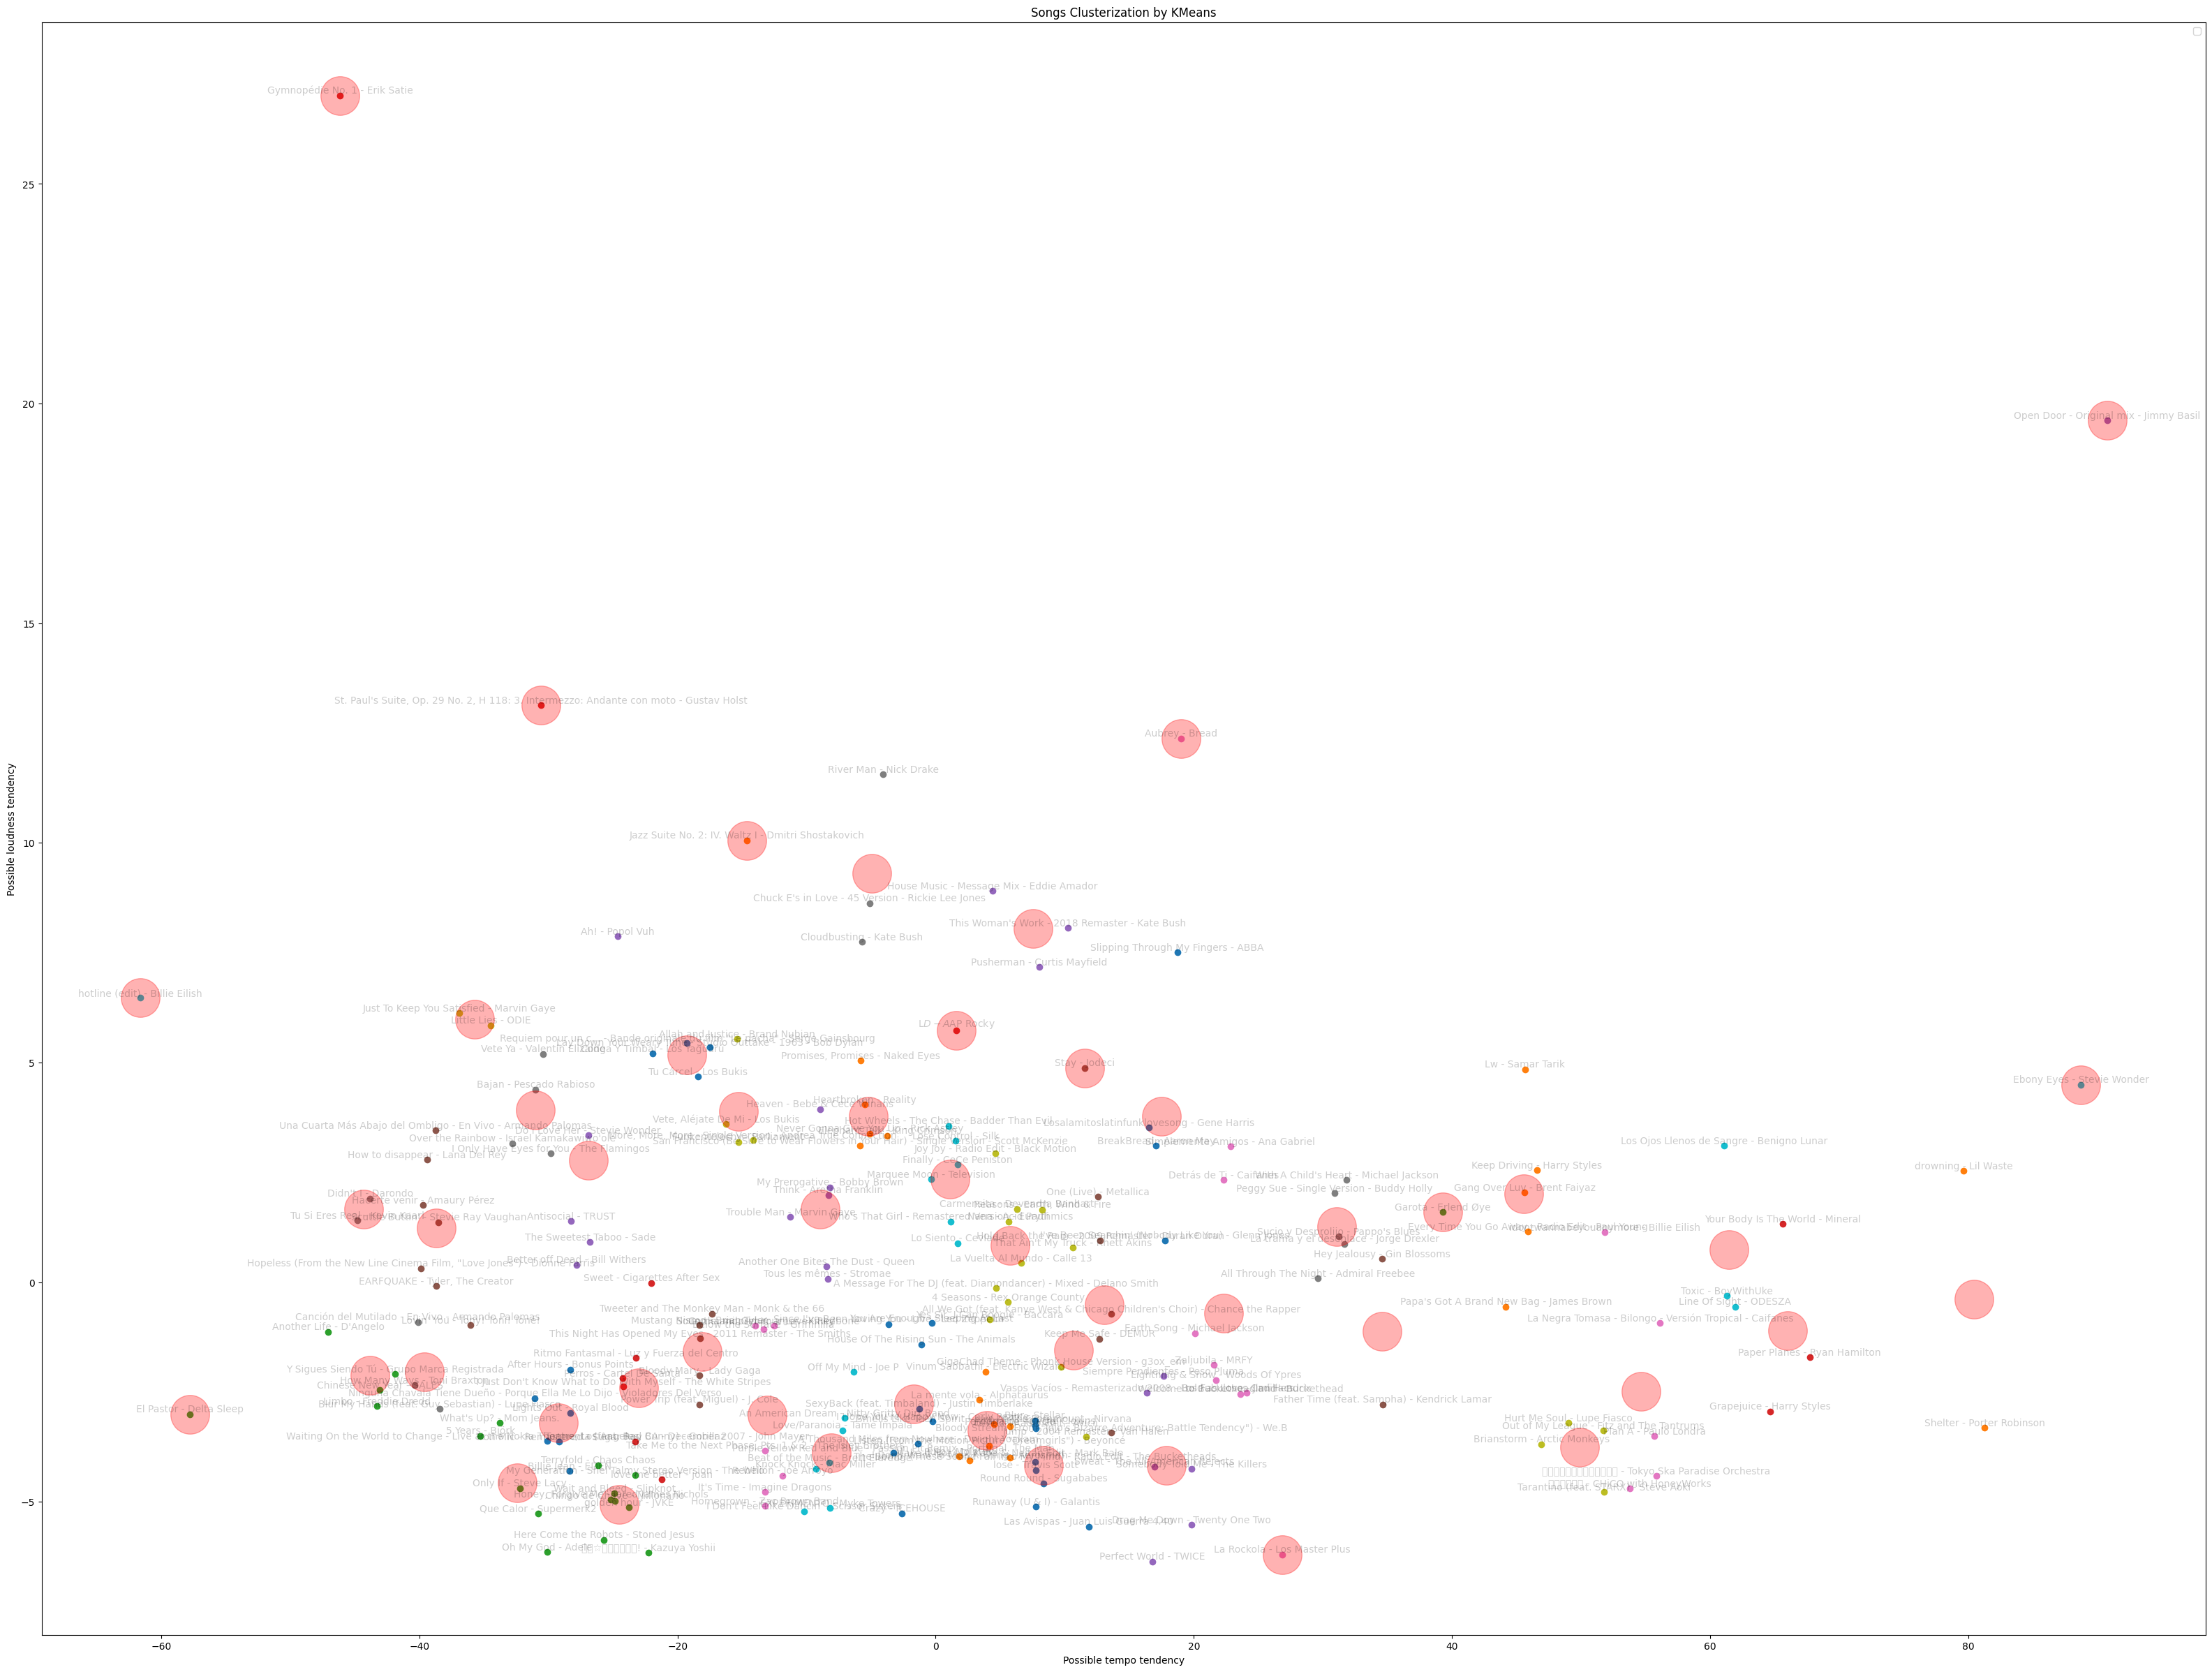

In [134]:
# Plotting figure
plt.figure(figsize=(40,30))

# Printing songs names
for (x,y,z) in zip(final_data_set[0], final_data_set[1], row_names_df[0]):
    plt.text(x,y,z,va='bottom', ha='center', alpha = 0.2)

# Ploting songs
for i in u_labels:
   plt.scatter(final_data_set[label == i][0] , final_data_set[label == i][1])

# Ploting centroids
plt.scatter(centroids[:,0] , centroids[:,1] , s = 1600, color = 'r', alpha = 0.3)

# Ploting titles
plt.title("Songs Clusterization by KMeans")
plt.xlabel("Possible tempo tendency")
plt.ylabel("Possible loudness tendency")

plt.legend()
plt.show()

        - Evaluation

In [135]:
# Obtaining labels for model evaluation
labels = kmeans.labels_

In [136]:
# Evaluating by Silhouette Coefficient. Range: (-1, 1) being 1 the best score
print(metrics.silhouette_score(final_data_set, labels, metric='euclidean'))

0.3803004727571189


In [137]:
# Evaluating by Calinski-Harabasz Index. The highest score, the better.
print(metrics.calinski_harabasz_score(final_data_set, labels))

879.5899235629571


In [138]:
# Evaluating by Davies-Bouldin Index. Being zero the lowest possible score, the minimum score, the better
print(davies_bouldin_score(final_data_set, labels))

0.6137676099683046
